# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               EnsDb.Hsapiens.v86, 
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [4]:
# Load genome
#annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86)
#seqlevelsStyle(annotations) <- 'UCSC'
#genome(annotations) <- 'hg38'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [6]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/"
assets.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Assets/"

cell.ranger.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/cellranger.symlinks/"

step1.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/1_preprocessing/"
step2.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/2_PeaksReformat/"
step3.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/3_SoupX/"
step4.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/"
log.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/log/"

amulet.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/amulet/"
scrublet.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/scrublet/"

In [7]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".4.4_doublet.cleanup.log", sep="")

In [8]:
log_open(log.file)

[1] "/nfs/lab/projects/mega_heart/CAREHF/multiome/log/2024-10-01.4.4_doublet.cleanup.log"

# Load sample list

In [9]:
# Load sample info
sample.info = read.table(paste(assets.dir, "sample.info", sep = ""), sep = "\t", header = TRUE)
# Build variables
sample.ls = sample.info$ID
cellranger.outs.ls = paste0(sample.info$CellRanger,
                            sample.info$Chamber, "/",
                            sample.info$ID, "/outs/")

# Check the paths r right
sample.ls[1]
cellranger.outs.ls[1]

[1] "KA_49_1_2_KA_45_1_2"

[1] "/nfs/lab/projects/CARE_HF/DATA/multiome/LA/KA_49_1_2_KA_45_1_2/outs/"

# Filter Amulet and Scrublet barcodes

In [10]:
qc.data = NULL

for (i in seq_along(sample.ls)){
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    sample.ID = sample.ls[i]
    log_print(paste("Processing: ", sample.ID))
    # Load sample
    adata <- readRDS(file = paste(step3.dir, sample, "_pre.filt.peaks.SoupX.rds", sep = ""))
    # Grab Idents
    cells = Cells(adata)
    ## AMULET
    log_print(" - Working with Amulet results")
    # Load Amulet results
    amulet.mult = read.table(paste(amulet.dir, sample.ID, "/MultipletBarcodes_01.txt", sep = "")) %>% t() %>% as.vector()
    amulet.metrics = read.table(paste(amulet.dir, sample.ID, "_singlecell.csv", sep = ""), sep = ',', header = TRUE)

    # Mark doublets
    amulet.mult.metadata <- rep("singlet", length(cells))
    names(amulet.mult.metadata) <- cells
    amulet.mult.metadata[amulet.mult] <- "multiplet"
    # add metadata column
    adata <- AddMetaData(adata, amulet.mult.metadata, col.name = "multiplet.amulet")

    # Amulet contamination plots
    file = paste(step4.dir, sample.ID,"_Amulet_UMAPs.png", sep = "")
    png(file, width = 1728, height = 576)
    p1 <- DimPlot(adata, reduction='umap.rna', group.by='multiplet.amulet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"), 
                  order = c("multiplet.amulet", "singlet")) + ggtitle('RNA')
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only') + theme(legend.position = "none") 

    p2 <- DimPlot(adata, reduction='umap.atac', group.by='multiplet.amulet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"), 
                  order = c("multiplet.amulet", "singlet")) + ggtitle('ATAC')
    p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only') + theme(legend.position = "none") 

    p3 <- DimPlot(adata, reduction='umap.wnn', group.by='multiplet.amulet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"), 
                  order = c("multiplet.amulet", "singlet")) + ggtitle('WNN')
    p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') 
    print(grid.arrange(p1, p2, p3, nrow = 1, top = textGrob(paste("Amulet  ", sample.ID, "\n", sep = ""),
                                                            gp = gpar(fontsize = 18, fontface = "bold"))))
    garbage <- dev.off()

    # Filter RDS
    adata.sing.amulet = subset(x = adata, subset = multiplet.amulet == "singlet")

    ##====================================================================================================##
    ## SCRUBLET
    log_print(" - Working with Scrublet results")
    # Load Scrublet results
    scrublet.thresh = read.table(paste(scrublet.dir, sample.ID, "_auto_threshold.txt", sep = ""), sep = "\t", header = FALSE)
    scrublet.metadata = read.table(paste(scrublet.dir, sample.ID, "_scrublet_predicted_doublets.txt", sep = ""), sep = "\t", header = FALSE)
    scrublet.mult <- as.vector(scrublet.metadata$V1[scrublet.metadata$V2 == 'True'])

    # Mark doublets
    scrublet.mult.metadata <- rep("singlet", length(cells))
    names(scrublet.mult.metadata) <- cells
    scrublet.mult.metadata[scrublet.mult] <- "multiplet"

    # add metadata column
    adata <- AddMetaData(adata, scrublet.mult.metadata, col.name = "multiplet.scrublet")
    file = paste(step4.dir, sample.ID,"_Scrublet_UMAPs.png", sep = "")
    png(file, width = 1728, height = 576)

    # Scrublet contamination plots for visualization of the original RDS 
    file = paste(step4.dir, sample.ID,"_Scrublet_UMAPs.png", sep = "")
    png(file, width = 1728, height = 576)
    p1 <- DimPlot(adata, reduction='umap.rna', group.by='multiplet.scrublet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"), 
                  order = c("multiplet.scrublet", "singlet")) + ggtitle('RNA')
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only') + theme(legend.position = "none") 

    p2 <- DimPlot(adata, reduction='umap.atac', group.by='multiplet.scrublet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"), 
                  order = c("multiplet.scrublet", "singlet")) + ggtitle('ATAC')
    p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only') + theme(legend.position = "none") 

    p3 <- DimPlot(adata, reduction='umap.wnn', group.by='multiplet.scrublet', pt.size = 1, 
                  cols = c("singlet" = "grey", "multiplet" = "purple"), 
                  order = c("multiplet.scrublet", "singlet")) + ggtitle('WNN')
    p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') 
    grid.arrange(p1, p2, p3, nrow = 1, top = textGrob(paste("Scrublet  ", sample.ID, "\n", sep = ""),
                                                            gp = gpar(fontsize = 18, fontface = "bold")))
    garbage <- dev.off()
    
    # Filter RDS
    adata.sing.amulet = AddMetaData(adata.sing.amulet, scrublet.mult.metadata, col.name = "multiplet.scrublet")   
    adata.sing.amulet.scrublet = subset(x = adata.sing.amulet, subset = multiplet.scrublet == "singlet")
        # Grab stats for RNA
        RNA.feature.mean = mean(adata.sing.amulet.scrublet$nFeature_RNA)
        RNA.feature.median = median(adata.sing.amulet.scrublet$nFeature_RNA)
        percent.mt.median = median(adata.sing.amulet.scrublet$percent.mt)
        percent.mt.mean = mean(adata.sing.amulet.scrublet$percent.mt)
    # Grab stats for ATAC
        atac.fragment.mean = mean(adata.sing.amulet.scrublet$atac_fragments)
        atac.fragment.median = median(adata.sing.amulet.scrublet$atac_fragments)
    # Check TSSenrichment
    DefaultAssay(adata.sing.amulet.scrublet) <- 'ATAC'
    suppressMessages(adata.sing.amulet.scrublet <- TSSEnrichment(adata.sing.amulet.scrublet))
        atac.TSSe.mean = mean(adata.sing.amulet.scrublet$TSS.enrichment)
        atac.TSSe.median = median(adata.sing.amulet.scrublet$TSS.enrichment)
    
    # Pileup QC
        amulet.scrublet.overlap <- intersect(amulet.mult, scrublet.mult)
        qc.data$sample.ID = rbind(qc.data$sample.ID, sample.ID)
        qc.data$barcodes = rbind(qc.data$barcodes, length(cells))
        qc.data$amulet.multiplets = rbind(qc.data$amulet.multiplets, length(amulet.mult))
        qc.data$scrublet.mult = rbind(qc.data$scrublet.mult, length(scrublet.mult))
        qc.data$amulet.scrublet.overlap = rbind(qc.data$amulet.scrublet.overlap, length(amulet.scrublet.overlap))
        qc.data$scrublet.thresh = rbind(qc.data$scrublet.thresh, scrublet.thresh)
        qc.data$RNA.feature.mean = rbind(qc.data$RNA.feature.mean, RNA.feature.mean)
        qc.data$RNA.feature.median = rbind(qc.data$RNA.feature.median, RNA.feature.median)
        qc.data$percent.mt.mean = rbind(qc.data$percent.mt.mean, percent.mt.mean)
        qc.data$percent.mt.median = rbind(qc.data$percent.mt.median, percent.mt.median)
        qc.data$atac.fragment.mean = rbind(qc.data$atac.fragment.mean, atac.fragment.mean)
        qc.data$atac.fragment.median = rbind(qc.data$atac.fragment.median, atac.fragment.median)
        qc.data$atac.TSSe.mean = rbind(qc.data$atac.TSSe.mean, atac.TSSe.mean)
        qc.data$atac.TSSe.median = rbind(qc.data$atac.TSSe.median, atac.TSSe.median)
        log_print(" - Done!!")

    ### Save  RDS
    file = paste(step4.dir, sample.ID, "_prefilt.Peaks.SoupX.RmMult.rds", sep = "")
    saveRDS(adata.sing.amulet.scrublet, file = file)

    ## Save barcodes
    file = paste(step4.dir, sample.ID, "_prefilt.Peaks.SoupX.RmMult.txt", sep = "")
    filtered_bcs <- colnames(adata.sing.amulet.scrublet[["RNA"]])
    write(filtered_bcs, file=file) 
    
}
file = paste(step4.dir, "Cell.res.qc", sep = "")
qc.data = as.data.frame(qc.data)
write.table(qc.data, file, sep='\t', row.names=FALSE, col.names=TRUE, quote=FALSE)

[1] "Processing:  KA_49_1_2_KA_45_1_2"
[1] " - Working with Amulet results"
TableGrob (2 x 3) "arrange": 4 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (2-2,2-2) arrange      gtable[layout]
3 3 (2-2,3-3) arrange      gtable[layout]
4 4 (1-1,1-3) arrange text[GRID.text.133]
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  QY_1880_1_2_QY_1879_1_2"
[1] " - Working with Amulet results"
TableGrob (2 x 3) "arrange": 4 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (2-2,2-2) arrange      gtable[layout]
3 3 (2-2,3-3) arrange      gtable[layout]
4 4 (1-1,1-3) arrange text[GRID.text.373]
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  QY_1882_1_2_QY_1881_1_2"
[1] " - Working with Amulet results"
TableGrob (2 x 3) "arrange": 4 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (2-2,2-2) arrange      gtable[layou

[1] " - Done!!"
[1] "Processing:  QY_1916_1_2_QY_1915_1_2"
[1] " - Working with Amulet results"
TableGrob (2 x 3) "arrange": 4 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange       gtable[layout]
2 2 (2-2,2-2) arrange       gtable[layout]
3 3 (2-2,3-3) arrange       gtable[layout]
4 4 (1-1,1-3) arrange text[GRID.text.5413]
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  QY_1969_1_2_QY_1968_1_2"
[1] " - Working with Amulet results"
TableGrob (2 x 3) "arrange": 4 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange       gtable[layout]
2 2 (2-2,2-2) arrange       gtable[layout]
3 3 (2-2,3-3) arrange       gtable[layout]
4 4 (1-1,1-3) arrange text[GRID.text.5653]
[1] " - Working with Scrublet results"
[1] " - Done!!"
[1] "Processing:  QY_2019_1_2_QY_2018_1_2"
[1] " - Working with Amulet results"
TableGrob (2 x 3) "arrange": 4 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange       gtable[layout]
2 2 (2-

In [11]:
qc.data = read.table(paste(step4.dir, "Cell.res.qc", sep = ""), sep = "\t", header = TRUE)
colnames(qc.data)[6] = "scrublet.thresh"
qc.data = qc.data %>% gather(multiplet.type, multiplets, c(3:5))
qc.data$multiplet.type = factor(qc.data$multiplet.type, 
                                levels = rev(c("amulet.multiplets", "scrublet.mult", "amulet.scrublet.overlap")))
qc.data$multiplets.pct = (qc.data$multiplets/qc.data$barcodes)*100

gather: reorganized (amulet.multiplets, scrublet.mult, amulet.scrublet.overlap) into (multiplet.type, multiplets) [was 36x14, now 108x13]


In [12]:
head(qc.data, n = 2)

,sample.ID,barcodes,scrublet.thresh,RNA.feature.mean,RNA.feature.median,percent.mt.mean,percent.mt.median,atac.fragment.mean,atac.fragment.median,atac.TSSe.mean,atac.TSSe.median,multiplet.type,multiplets,multiplets.pct
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>
1,KA_49_1_2_KA_45_1_2,4431,0.2305384,2056.108,1857,0.2204059,0.06993007,18919.09,15790,4.037533,3.984604,amulet.multiplets,449,10.133153
2,QY_1880_1_2_QY_1879_1_2,9506,0.1266982,1299.869,1069,0.6035232,0.32594524,10026.59,6920,4.030471,3.876124,amulet.multiplets,660,6.942983


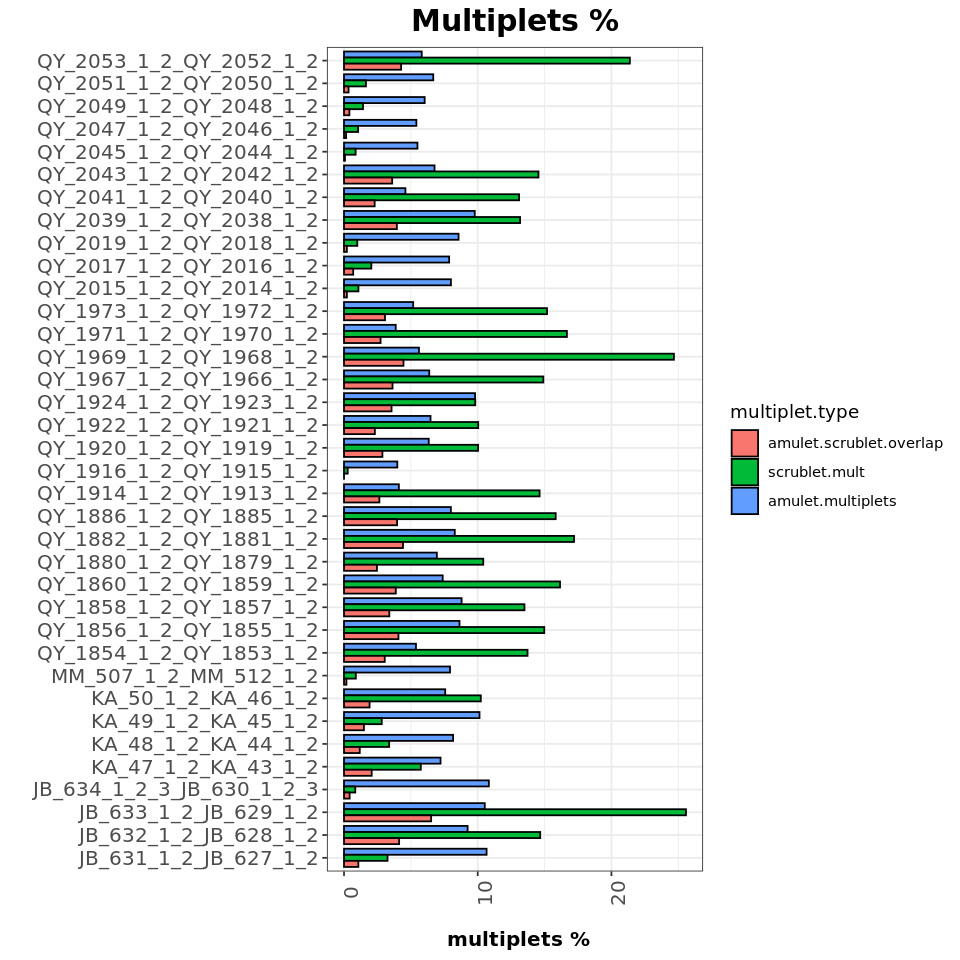

In [13]:
options(repr.plot.width=8, repr.plot.height=8)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = multiplets.pct, fill = multiplet.type)) + 
            theme_bw () +
            labs(y= "\n multiplets %", x = "", title = "Multiplets %") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg1

gather: reorganized (atac.fragment.mean, multiplet.type) into (Stat, median) [was 108x14, now 216x14]


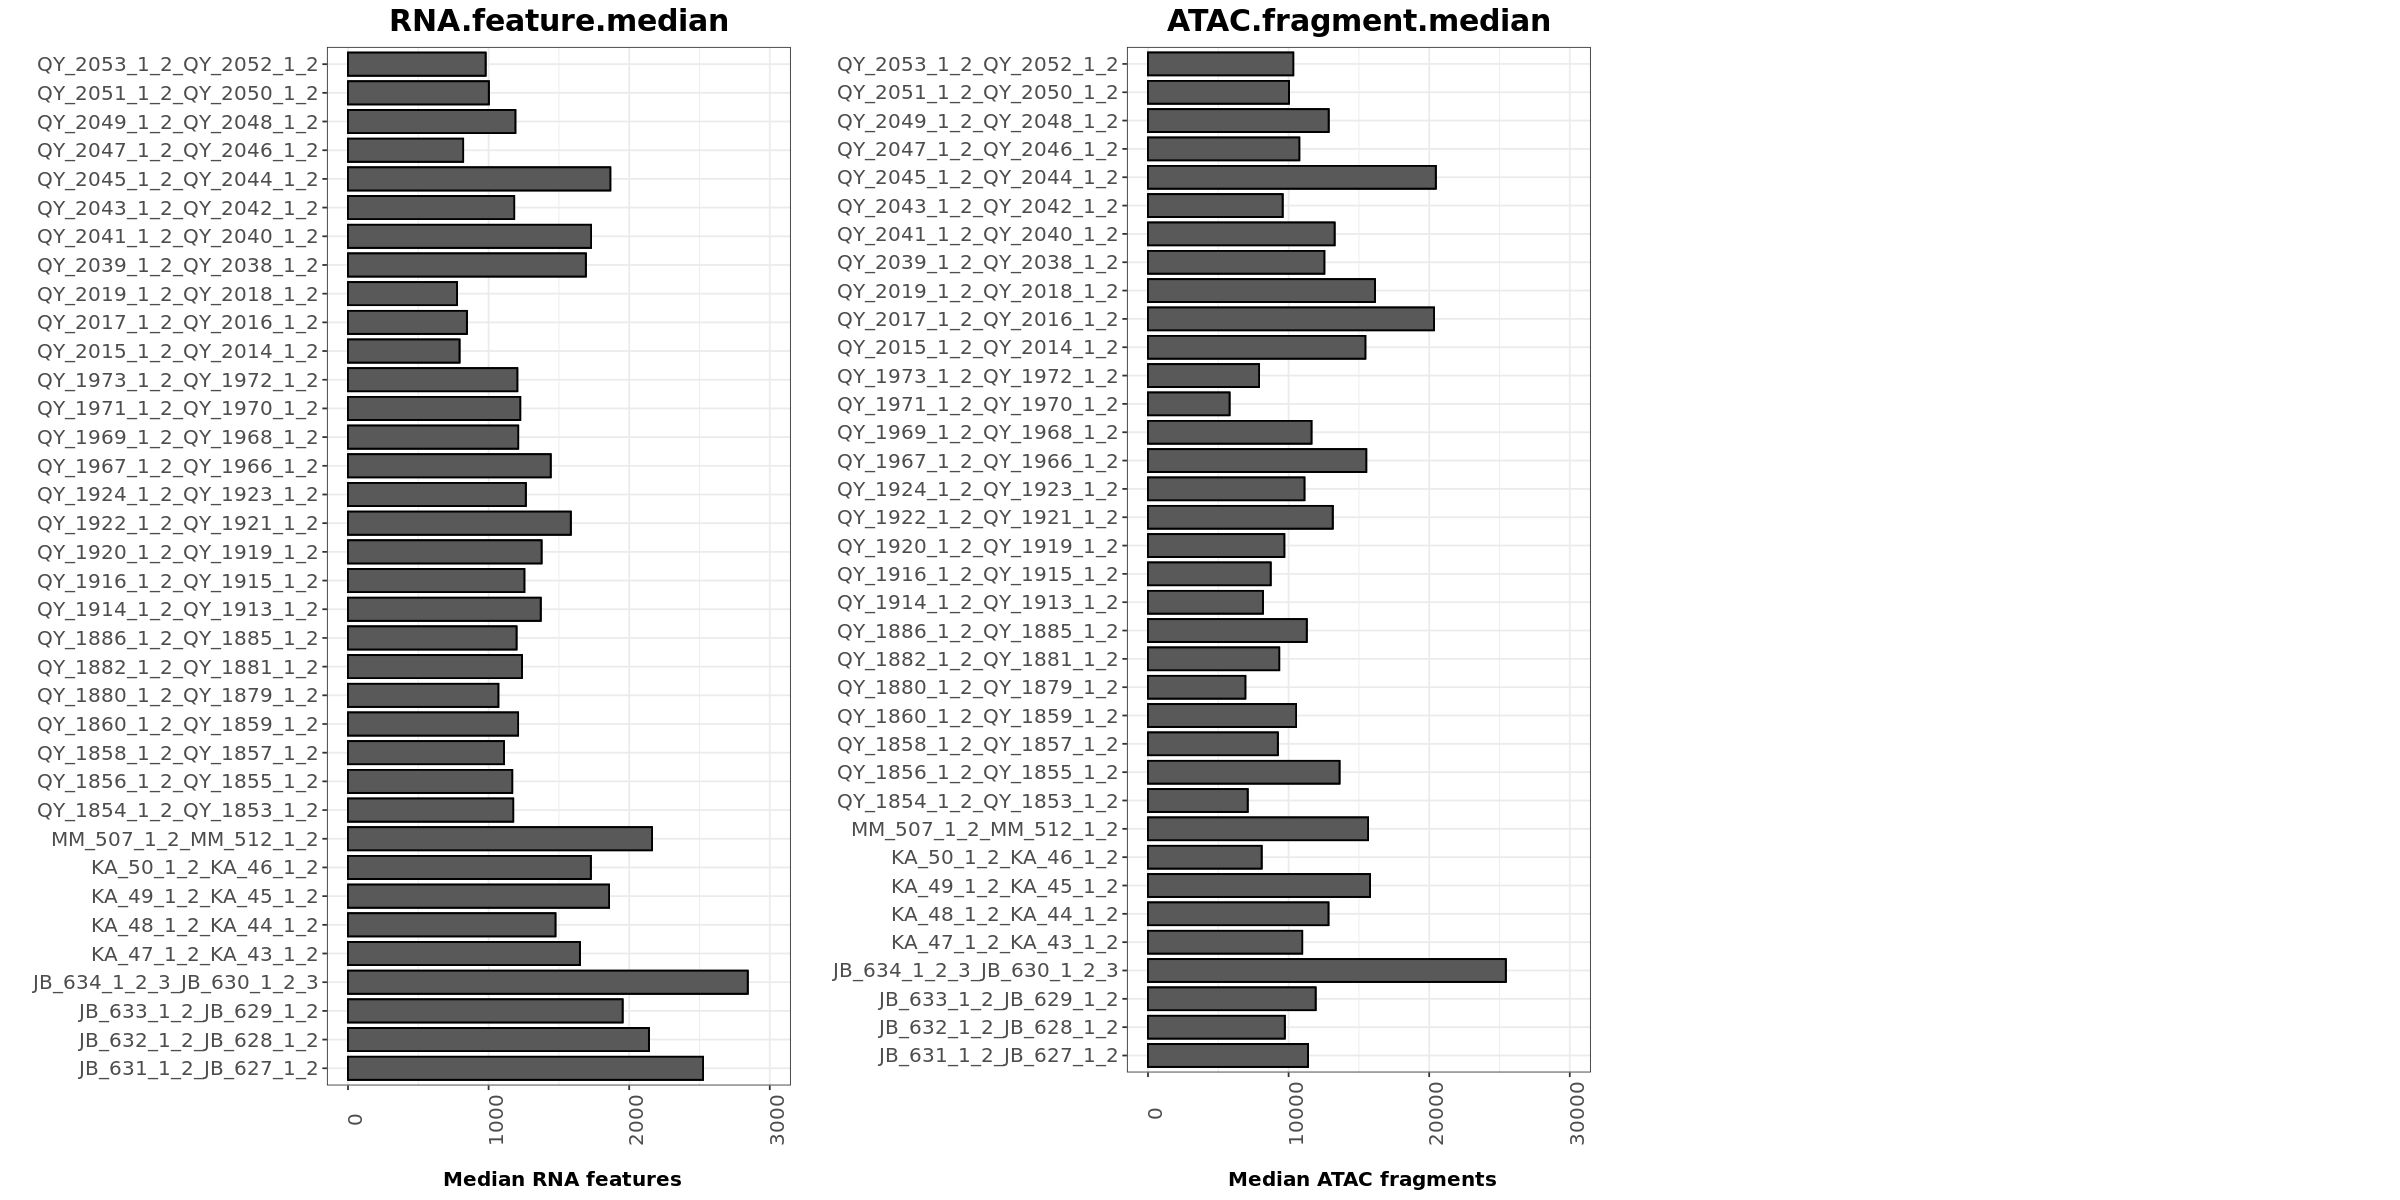

In [14]:
# Plot median features
options(repr.plot.width=10, repr.plot.height=7)
mat <- qc.data %>% gather(Stat, median, c(8,12))
mat$Stat = factor(mat$Stat, levels = c('RNA.feature.median', 'atac.fragment.median'))


width = 0.8
gg2 = ggplot(qc.data, aes(x= sample.ID, y = RNA.feature.median)) + 
            theme_bw () +
            labs(y= "\n Median RNA features", x = "", title = "RNA.feature.median") +
            geom_bar(stat="identity", 
                     position = position_dodge(width = width), width = width,
                     colour="black") +
            ylim(0,3000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg3 = ggplot(qc.data, aes(x= sample.ID, y = atac.fragment.median)) + 
            theme_bw () +
            labs(y= "\n Median ATAC fragments", x = "", title = "ATAC.fragment.median") +
            geom_bar(stat="identity", 
                     position = position_dodge(width = width), width = width,
                     colour="black") +
            ylim(0,30000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
options(repr.plot.width=20, repr.plot.height=10)
grid.arrange(gg2, gg3, ncol=3)

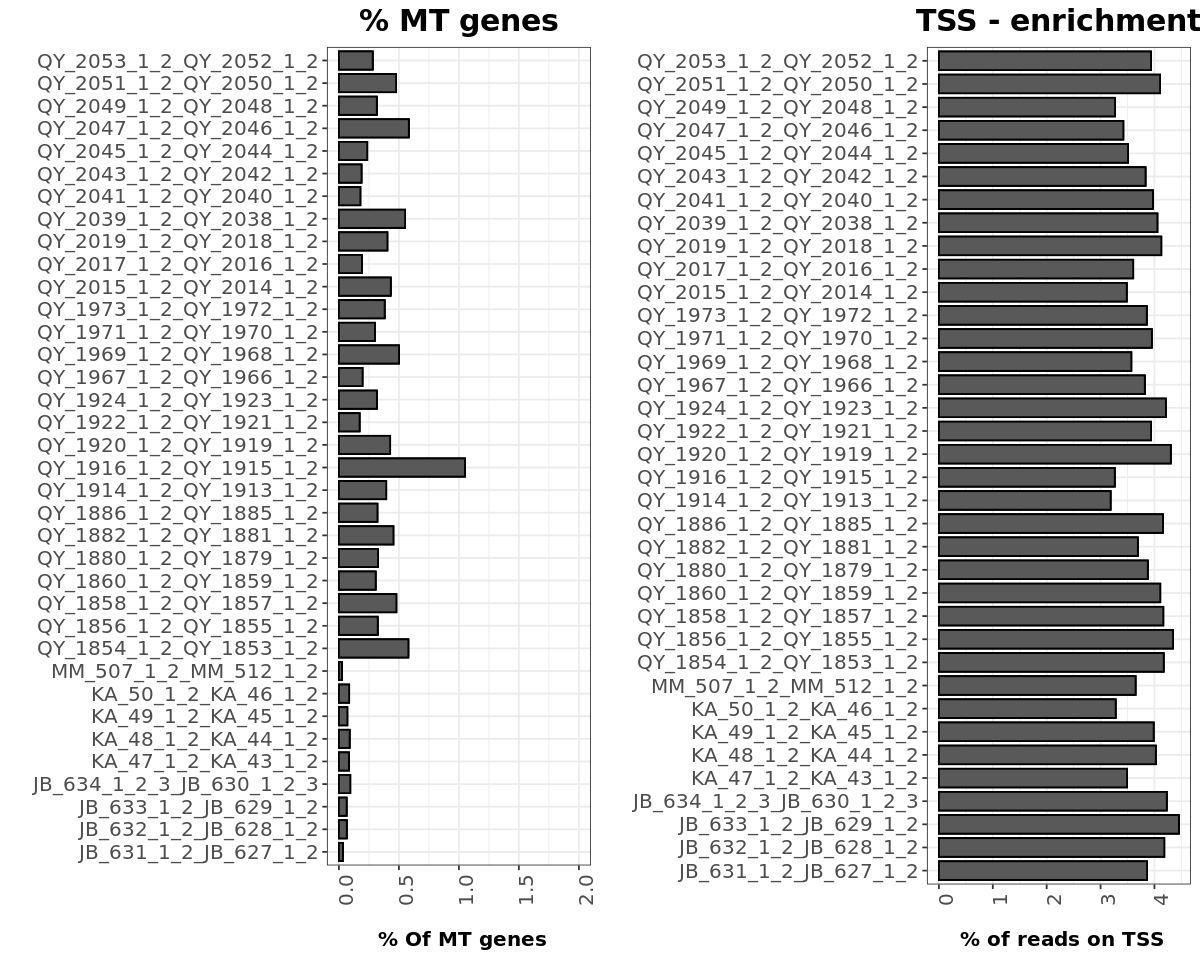

In [15]:
options(repr.plot.width=5, repr.plot.height=5)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = percent.mt.median)) + 
            theme_bw () +
            labs(y= "\n % Of MT genes", x = "", title = "% MT genes") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            ylim(0, 2)+
            coord_flip()

gg2 = ggplot(qc.data, aes(x= sample.ID, y = atac.TSSe.median)) + 
            theme_bw () +
            labs(y= "\n % of reads on TSS", x = "", title = "TSS - enrichment") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

options(repr.plot.width=10, repr.plot.height=8)
grid.arrange(gg1, gg2, ncol=2)

In [16]:
qc.data = read.table(paste(step4.dir, "Cell.res.qc", sep = ""), sep = "\t", header = TRUE)
colnames(qc.data)[6] = "scrublet.thresh"
qc.data$final.barcodes = round(qc.data$barcodes - qc.data$amulet.multiplets - qc.data$scrublet.mult + (qc.data$amulet.scrublet.overlap/2))

In [17]:
qc.data = qc.data %>% gather(barcodes.type, barcodes, c(2,15))
qc.data$barcodes.type = factor(qc.data$barcodes.type, 
                                levels = rev(c("barcodes", "final.barcodes")))

gather: reorganized (final.barcodes) into (barcodes.type) [was 36x15, now 72x15]


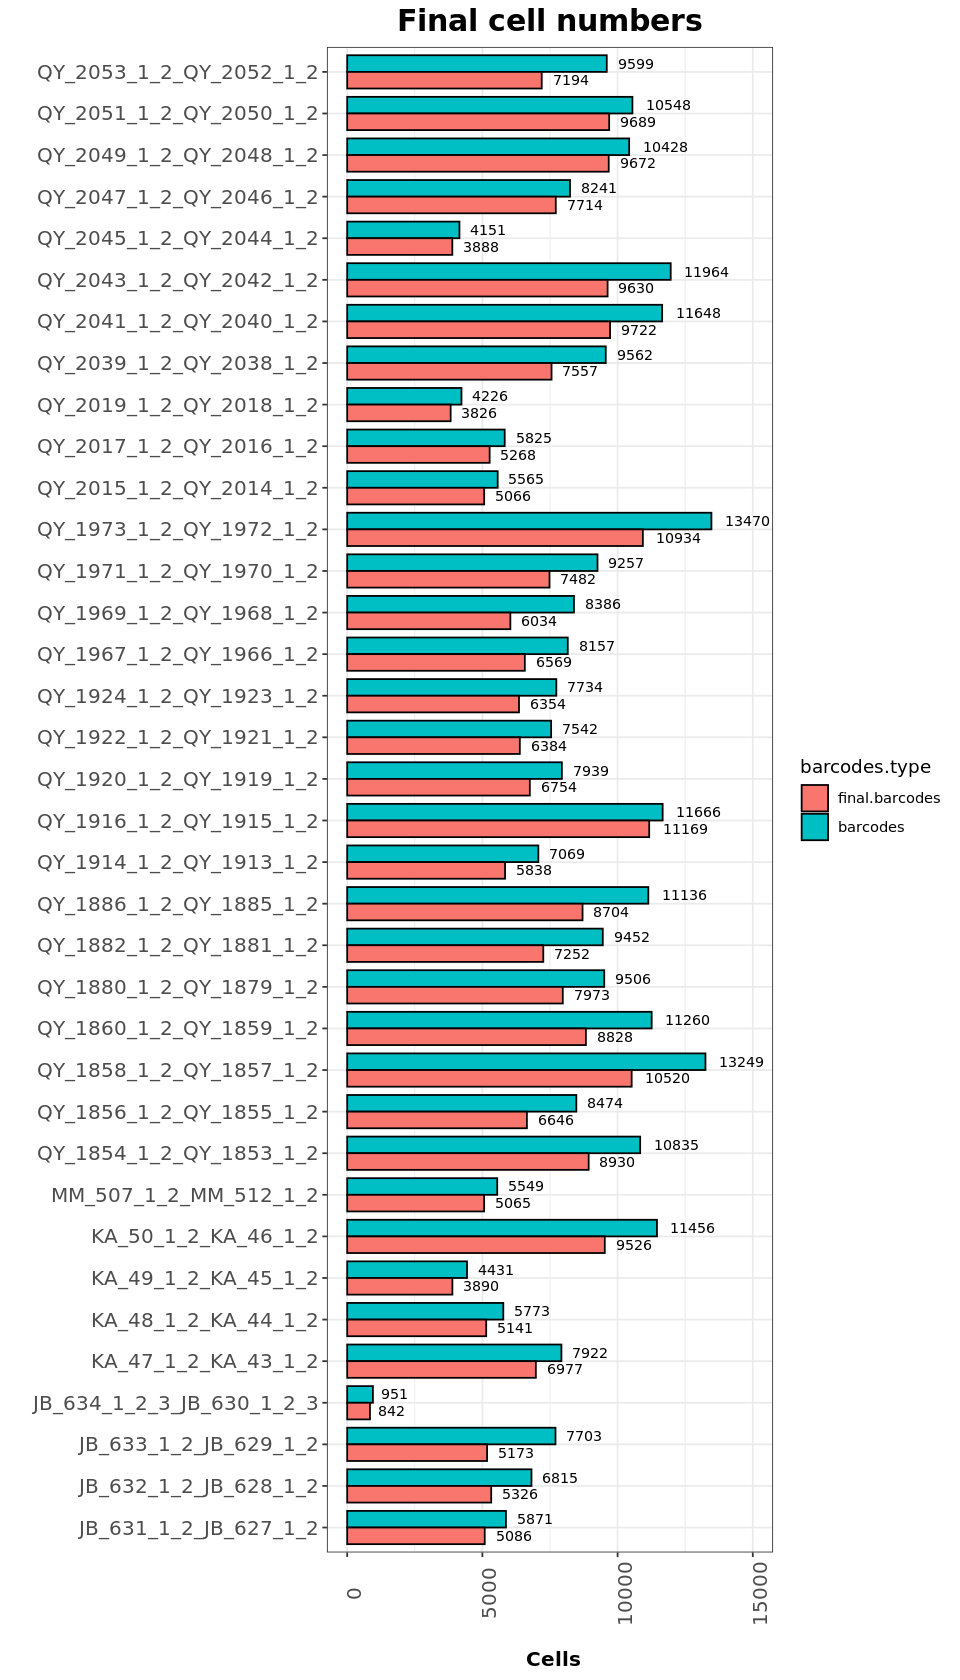

In [18]:
options(repr.plot.width=8, repr.plot.height=14)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = barcodes, fill = barcodes.type, label = barcodes)) + 
            theme_bw () +
            labs(y= "\n Cells", x = "", title = "Final cell numbers") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            ylim(0, 15000)+
            coord_flip()+
            geom_text(hjust = -0.3, size = 3, position = position_dodge(width = width))
gg1

In [19]:
"This is actually an estimate, I should just note down the cellnumbers from the object"

[1] "This is actually an estimate, I should just note down the cellnumbers from the object"

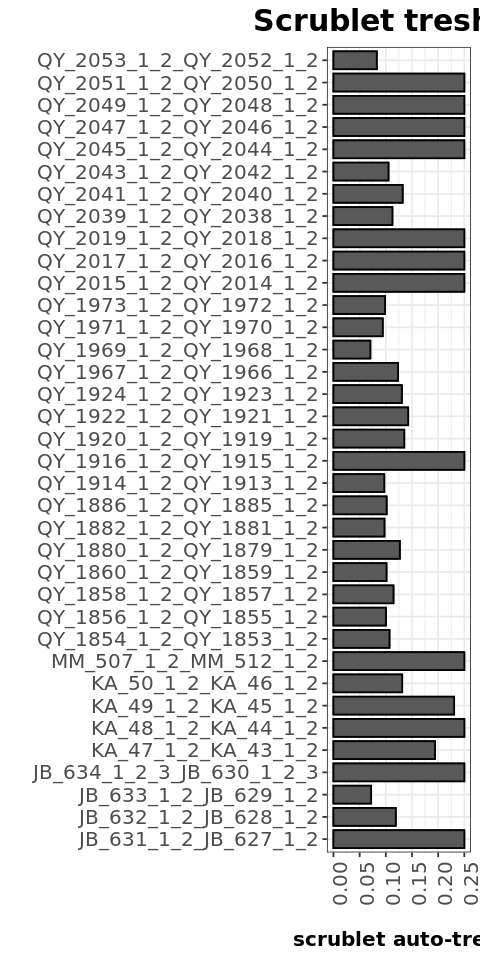

In [20]:
options(repr.plot.width=4, repr.plot.height=8)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = scrublet.thresh)) + 
            theme_bw () +
            labs(y= "\n scrublet auto-tresh", x = "", title = "Scrublet treshold") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg1

In [1]:
dir("/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/", pattern = "rds")

[1] "JB_631_1_2_JB_627_1_2_prefilt.Peaks.SoupX.RmMult.rds"    
 [2] "JB_632_1_2_JB_628_1_2_prefilt.Peaks.SoupX.RmMult.rds"    
 [3] "JB_633_1_2_JB_629_1_2_prefilt.Peaks.SoupX.RmMult.rds"    
 [4] "JB_634_1_2_3_JB_630_1_2_3_prefilt.Peaks.SoupX.RmMult.rds"
 [5] "KA_47_1_2_KA_43_1_2_prefilt.Peaks.SoupX.RmMult.rds"      
 [6] "KA_48_1_2_KA_44_1_2_prefilt.Peaks.SoupX.RmMult.rds"      
 [7] "KA_49_1_2_KA_45_1_2_prefilt.Peaks.SoupX.RmMult.rds"      
 [8] "KA_50_1_2_KA_46_1_2_prefilt.Peaks.SoupX.RmMult.rds"      
 [9] "MM_507_1_2_MM_512_1_2_prefilt.Peaks.SoupX.RmMult.rds"    
[10] "QY_1854_1_2_QY_1853_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[11] "QY_1856_1_2_QY_1855_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[12] "QY_1858_1_2_QY_1857_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[13] "QY_1860_1_2_QY_1859_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[14] "QY_1880_1_2_QY_1879_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[15] "QY_1882_1_2_QY_1881_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[16] "QY_1886_1_2_QY_1885_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[17] "QY_1914_1_2_QY_1913_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[18] "QY_1916_1_2_QY_1915_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[19] "QY_1920_1_2_QY_1919_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[20] "QY_1922_1_2_QY_1921_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[21] "QY_1924_1_2_QY_1923_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[22] "QY_1967_1_2_QY_1966_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[23] "QY_1969_1_2_QY_1968_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[24] "QY_1971_1_2_QY_1970_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[25] "QY_1973_1_2_QY_1972_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[26] "QY_2015_1_2_QY_2014_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[27] "QY_2017_1_2_QY_2016_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[28] "QY_2019_1_2_QY_2018_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[29] "QY_2039_1_2_QY_2038_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[30] "QY_2041_1_2_QY_2040_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[31] "QY_2043_1_2_QY_2042_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[32] "QY_2045_1_2_QY_2044_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[33] "QY_2047_1_2_QY_2046_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[34] "QY_2049_1_2_QY_2048_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[35] "QY_2051_1_2_QY_2050_1_2_prefilt.Peaks.SoupX.RmMult.rds"  
[36] "QY_2053_1_2_QY_2052_1_2_prefilt.Peaks.SoupX.RmMult.rds"

sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/JB_631_1_2_JB_627_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/JB_632_1_2_JB_628_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/JB_633_1_2_JB_629_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/JB_634_1_2_3_JB_630_1_2_3_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/KA_47_1_2_KA_43_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/KA_48_1_2_KA_44_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/KA_49_1_2_KA_45_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/KA_50_1_2_KA_46_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/MM_507_1_2_MM_512_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1854_1_2_QY_1853_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1856_1_2_QY_1855_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1858_1_2_QY_1857_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1860_1_2_QY_1859_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1880_1_2_QY_1879_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1882_1_2_QY_1881_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1886_1_2_QY_1885_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1914_1_2_QY_1913_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1916_1_2_QY_1915_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1920_1_2_QY_1919_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1922_1_2_QY_1921_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1924_1_2_QY_1923_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1967_1_2_QY_1966_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1969_1_2_QY_1968_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1971_1_2_QY_1970_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_1973_1_2_QY_1972_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2015_1_2_QY_2014_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2017_1_2_QY_2016_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2019_1_2_QY_2018_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2039_1_2_QY_2038_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2041_1_2_QY_2040_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2043_1_2_QY_2042_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2045_1_2_QY_2044_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2047_1_2_QY_2046_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2049_1_2_QY_2048_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2051_1_2_QY_2050_1_2_prefilt.Peaks.SoupX.RmMult.rds .
sshpass -p ltucciarone1 scp -P 2088 luca@ophelia.ucsd.edu:/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/4_Doublet_cleanup/QY_2053_1_2_QY_2052_1_2_prefilt.Peaks.SoupX.RmMult.rds .

